In [1]:
!pip install pretty-confusion-matrix
!pip install transformers
!pip install pytorch-transformers
!pip install -U sentence-transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.5/199.5 kB 1.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.1/73.1 kB 4.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 156.7/156.7 kB 4.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.8/68.8 kB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.7/41.7 kB 4.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.8/98.8 kB 6.8 MB/s eta 0:00:00
  Attempting uninstall: tomli
    Found existing installation: tomli 2.0.1
    Uninstalling tomli-2.0.1:
      Successfully uninstalled tomli-2.0.1
  Attempting uninstall: pyflakes
    Found existing installation: pyflakes 2.4.0
    Uninstalling pyflakes-2.4.0:
      Successfully uninstalled pyflakes-2.4.0
  Attempting uninstall: pycodestyle
    Found existing installation: pycodestyle 2.8.0
    Uninstalling pycodestyle-2.8.0:
      Successfully uninstalled pycodestyle-2.8.0
  Attempting uninstall: flake8
    Fou

In [2]:
import numpy as np 
import pandas as pd 
import csv
import pickle
import matplotlib.pyplot as plt

In [3]:
import tensorflow as tf
from keras.layers import Bidirectional, Input, Dense, Layer, Dropout, LSTM, RepeatVector, Concatenate, Flatten
from keras.models import Sequential, Model
from tensorflow.python.keras.callbacks import EarlyStopping
from keras import backend as K

In [4]:
print(tf.__version__)

2.6.4


In [5]:
### HYPERPARAMETERS
POLITENESS_LEVELS = 5
EPOCHS = 30
MAXLEN = 768 # Since SciBERT returns 768 embeddings vector
LSTM_UNITS = 256
is_BiLSTM = False # Flag to automate other pre-processing for With or Without BiLSTM variants

## ADD PATH OF THE PRE-TRAINED MODEL HERE ##
SAVE_PATH = "./Ablation-Model.h5" 

In [6]:
### CHOOSE THE EMBEDDING VARIANT YOU WANT TO TRY ###

## SCI-BERT 
# name = 'SCIBERT'
# embed_model_name = 'gsarti/scibert-nli'

## TOXIC-BERT
# name = 'TOXIC-BERT'
# embed_model_name = 'troesy/toxicBERT_3epoch'

## HATE-BERT
name = 'HATE-BERT'
embed_model_name = 'GroNLP/hateBERT'

# LOAD DATASET

In [7]:
# LOAD EMBEDS DATASET

def loadPickle(name):
    start_path = '/kaggle/input/iitpolitenesslevels/'
    LOAD_PATH = start_path+name+'_train.pickle'
    with open(LOAD_PATH, 'rb') as handle:
        train_embeds = pickle.load(handle)
        handle.close()

    LOAD_PATH = start_path+name+'_test.pickle'
    with open(LOAD_PATH, 'rb') as handle:
        test_embeds = pickle.load(handle)
        handle.close()
        
    LOAD_PATH = start_path+name+'_val.pickle'
    with open(LOAD_PATH, 'rb') as handle:
        val_embeds = pickle.load(handle)
        handle.close()
        
    y_train = pd.read_csv(start_path+'y_train.csv')
    y_val = pd.read_csv(start_path+'y_val.csv')
    y_test = pd.read_csv(start_path+'y_test.csv')
    
    print('\n***** LOADED '+ name+' *****\n')
    print(f'TRAIN SHAPE : {train_embeds.shape}\nTEST SHAPE : {test_embeds.shape}\nVAL SHAPE : {val_embeds.shape}\nY-TRAIN SHAPE : {y_train.shape}\nY-TEST SHAPE : {y_test.shape}\nY-VAL SHAPE : {y_val.shape}')

    return train_embeds, test_embeds, val_embeds, y_train, y_test, y_val

# /kaggle/input/iitpolitenesslevels/SCIBERT_train.pickle

In [8]:
train_embeds, test_embeds, val_embeds, y_train, y_test, y_val = loadPickle(name)

2022-12-05 04:17:19.868070: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero



***** LOADED HATE-BERT *****

TRAIN SHAPE : (4556, 1, 768)
TEST SHAPE : (855, 1, 768)
VAL SHAPE : (284, 1, 768)
Y-TRAIN SHAPE : (4556, 5)
Y-TEST SHAPE : (855, 5)
Y-VAL SHAPE : (284, 5)


2022-12-05 04:17:19.945784: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-05 04:17:19.946581: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-05 04:17:19.948483: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-05 04:17:19.948822: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA 

### LOAD EMBEDDING MODEL

In [9]:
from transformers import pipeline, AutoTokenizer, AutoModel

In [10]:
tokenizer = AutoTokenizer.from_pretrained(embed_model_name) 
embed_model = AutoModel.from_pretrained(embed_model_name)

Downloading:   0%|          | 0.00/151 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/420M [00:00<?, ?B/s]

Some weights of the model checkpoint at GroNLP/hateBERT were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [11]:
def sent2embed(model, sent):
    inputs = tokenizer(sent, return_tensors="pt", padding=True, truncation=True, max_length=512)
    outputs = model(**inputs)
    last_hidden_states = outputs.last_hidden_state
    return outputs

# SAMPLE SCIBERT
sent = ['This work studies the predictive uncertainty issue of deep learning models.']
outputs = sent2embed(embed_model, sent)
outputs[1].shape


torch.Size([1, 768])

In [12]:
# PRE-PROCESS
def Embed(reviews, y_train, model):
    embed_arr = []
    start = reviews.index[0]
    for idx in range(len(reviews.index)):
        print(start + idx)
        outputs = sent2embed(model, reviews.loc[start+idx])
        embed_arr.append([outputs[1].detach().numpy()[0]])

    embed_train_arr = tf.stack(embed_arr)

    return embed_train_arr, y_train

# MODEL

### ATTENTION LAYER

In [13]:
class Attention(Layer):
    
    def __init__(self, return_sequences=True, **kwargs):
        super(Attention,self).__init__()
        self.return_sequences = return_sequences
        super(Attention, self).__init__(**kwargs)

    def get_config(self):
        config = super(Attention, self).get_config().copy()
        config.update({
            'return_sequences': self.return_sequences , 
        })
        return config


    def build(self, input_shape):
        
        self.W=self.add_weight(name="att_weight", shape=(input_shape[-1],1),
                               initializer="normal")
        self.b=self.add_weight(name="att_bias", shape=(input_shape[1],1),
                               initializer="zeros")
        
        super(Attention,self).build(input_shape)
        
    def call(self, x):
        e =K.squeeze(K.tanh(K.dot(x,self.W)+self.b),axis=-1)
        a =K.softmax(e)
        a=K.expand_dims(a,axis=-1)
        output = x*a
        
        return K.sum(output, axis=1) 

In [14]:
if not is_BiLSTM:
    ## ONLY IF BiLSTM NOT there -- REDUCE DIMENSION OF DATASET BY 1DIM 
    train_embeds = np.array([row[0] for row in train_embeds ])
    test_embeds = np.array([row[0] for row in test_embeds ])
    val_embeds = np.array([row[0] for row in val_embeds ])


## DEFINE MODELS

### A) BiLSTM  

In [15]:
# embed = Input(shape=  (MAXLEN, ), name='INPUT REVIEW') 
# embedding_layer = Embedding(input_dim = VOCAB_LEN, output_dim = EMBEDDING_DIMENSION, 
#                             weights=[Embedding_Matrix], input_length=MAXLEN, trainable=True, name='CUSTOM_EMBEDDING')(embed)
# # print(embedding_layer.shape)
# biLSTM = Bidirectional(LSTM(LSTM_UNITS ,dropout=0.2, return_sequences=False) , name='BILSTM' )(embedding_layer) 

# flatten = Flatten()(biLSTM)
# politeness_output = Dense(POLITENESS_LEVELS, activation='softmax', name='POLITENESS_OUTPUT')(flatten)

# model = Model(inputs=embed, outputs=politeness_output)

### B) SCIBERT/ TOXIC-BERT / HATE-BERT VARIANTS

In [16]:
embed = Input(shape=  (MAXLEN,), name='INPUT') # without BiLSTM
politeness_output = Dense(POLITENESS_LEVELS, activation='softmax', name='POLITENESS_OUTPUT')(embed)
model = Model(inputs=embed, outputs=politeness_output)

## COMPILE MODEL

In [17]:
# metrics =[ 
#     'accuracy', 
#     tf.keras.metrics.Precision(), 
#     tf.keras.metrics.Recall()
# ]

model.compile(loss= 'categorical_crossentropy',
                        optimizer='adam', 
                        metrics=['accuracy']) 


model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
INPUT (InputLayer)           [(None, 768)]             0         
_________________________________________________________________
POLITENESS_OUTPUT (Dense)    (None, 5)                 3845      
Total params: 3,845
Trainable params: 3,845
Non-trainable params: 0
_________________________________________________________________


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


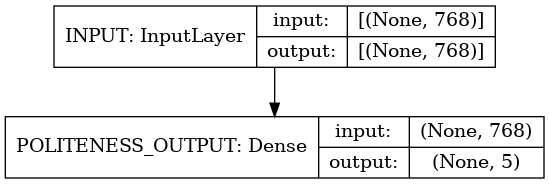

In [18]:
tf.keras.utils.plot_model(model, to_file='politeness_model.png', show_shapes=True)

## TRAIN MODEL

In [19]:
history = model.fit(train_embeds, 
                    y = y_train,  
                    validation_data = (test_embeds, y_test),
                    epochs = EPOCHS,
                   shuffle=True,
                   verbose=2
                )

2022-12-05 04:18:00.932858: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/30
143/143 - 2s - loss: 1.5444 - accuracy: 0.2932 - val_loss: 1.4610 - val_accuracy: 0.3579
Epoch 2/30
143/143 - 0s - loss: 1.4237 - accuracy: 0.3946 - val_loss: 1.4045 - val_accuracy: 0.3789
Epoch 3/30
143/143 - 0s - loss: 1.3575 - accuracy: 0.4313 - val_loss: 1.3755 - val_accuracy: 0.3754
Epoch 4/30
143/143 - 0s - loss: 1.3152 - accuracy: 0.4519 - val_loss: 1.3066 - val_accuracy: 0.4515
Epoch 5/30
143/143 - 0s - loss: 1.2746 - accuracy: 0.4748 - val_loss: 1.3184 - val_accuracy: 0.4468
Epoch 6/30
143/143 - 0s - loss: 1.2495 - accuracy: 0.4842 - val_loss: 1.2879 - val_accuracy: 0.4667
Epoch 7/30
143/143 - 0s - loss: 1.2223 - accuracy: 0.4967 - val_loss: 1.2872 - val_accuracy: 0.4643
Epoch 8/30
143/143 - 0s - loss: 1.2071 - accuracy: 0.4958 - val_loss: 1.2365 - val_accuracy: 0.4936
Epoch 9/30
143/143 - 0s - loss: 1.1951 - accuracy: 0.5024 - val_loss: 1.2295 - val_accuracy: 0.4936
Epoch 10/30
143/143 - 0s - loss: 1.1706 - accuracy: 0.5151 - val_loss: 1.2584 - val_accuracy: 0.4632

In [20]:
# SAVE MODEL
SAVE_PATH = './Politeness_'+name+'.h5'
model.save(SAVE_PATH, overwrite=True, save_format="tf")
print("Weights Saved")

Weights Saved


In [21]:
# LOAD MODEL
from keras.models import load_model
LOAD_PATH = SAVE_PATH
model = load_model(LOAD_PATH, custom_objects={'Attention': Attention})

print("MODEL LOADED\n\n")

model.evaluate(test_embeds, y_test)

MODEL LOADED


27/27 [==============================] - 0s 2ms/step - loss: 1.1242 - accuracy: 0.5450


[1.1241875886917114, 0.5450292229652405]

## ANALYSIS

In [22]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

## VALIDATION

In [23]:
metrics_keys = list(history.history.keys())

loss = history.history[metrics_keys[0]]
accuracy = history.history[metrics_keys[1]]
val_loss = history.history[metrics_keys[2]]
val_accuracy = history.history[metrics_keys[3]]


print("\nACCURACY : " , accuracy)
print("\nLOSS : " , loss)
print("\nVAL LOSS : " , val_loss)
print("\nVAL ACCURACY : " , val_accuracy)


ACCURACY :  [0.29323968291282654, 0.39464443922042847, 0.4312993884086609, 0.45193150639533997, 0.4747585654258728, 0.48419666290283203, 0.49670764803886414, 0.49582967162132263, 0.5024144053459167, 0.5151448845863342, 0.5188761949539185, 0.5278753042221069, 0.5335820913314819, 0.5359964966773987, 0.5375329256057739, 0.5428007245063782, 0.5531167984008789, 0.5559701323509216, 0.5603599548339844, 0.5572870969772339, 0.5629938244819641, 0.5722124576568604, 0.5649692416191101, 0.5645303130149841, 0.5748463273048401, 0.5834065079689026, 0.5812115669250488, 0.5928446054458618, 0.5798946619033813, 0.5792361497879028]

LOSS :  [1.5443546772003174, 1.423693060874939, 1.3574798107147217, 1.3152137994766235, 1.2746045589447021, 1.2495336532592773, 1.2222858667373657, 1.2071174383163452, 1.1951411962509155, 1.170579195022583, 1.1664916276931763, 1.1564364433288574, 1.1372196674346924, 1.1331020593643188, 1.127987265586853, 1.1104516983032227, 1.0962494611740112, 1.0963653326034546, 1.08729076385

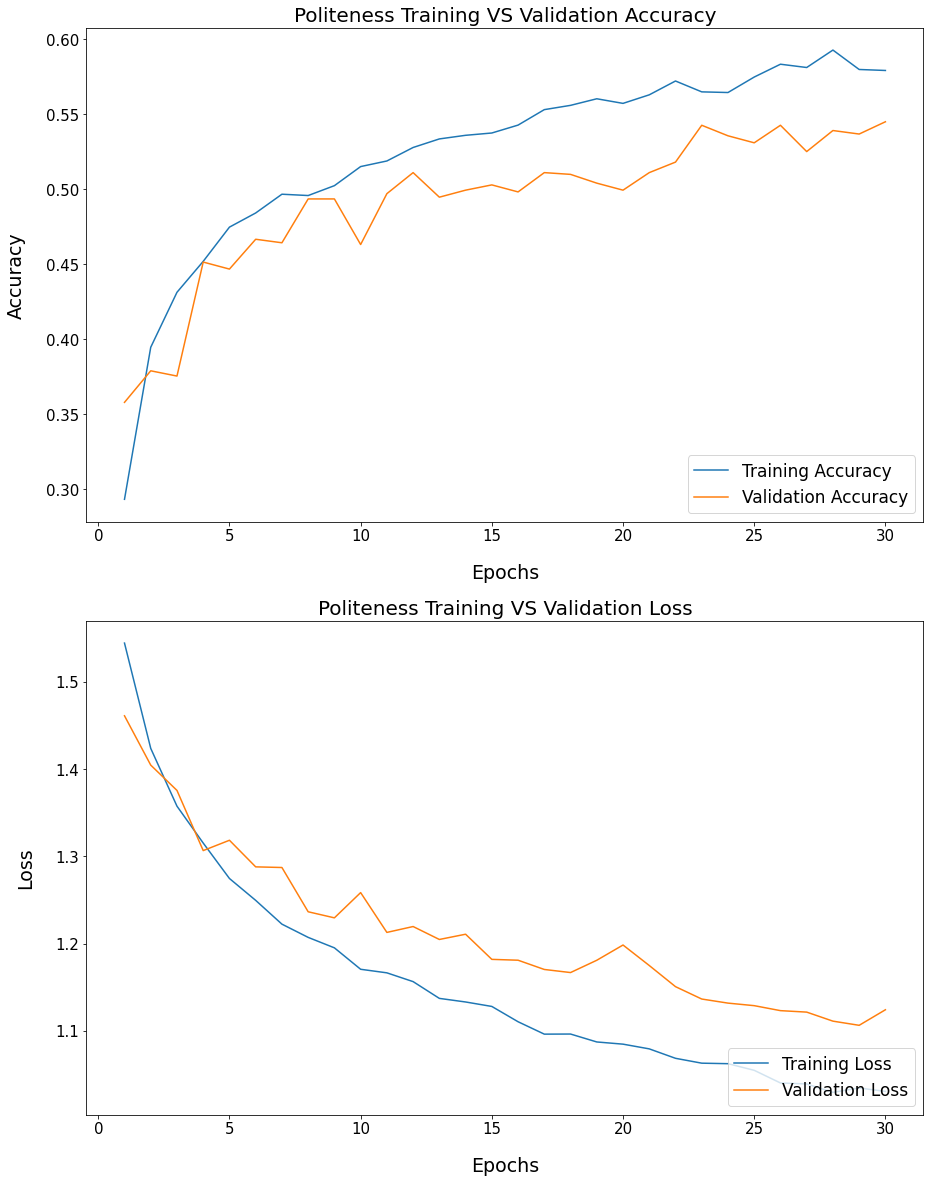

In [24]:
metrics = history.history['loss']
epochs_range = range(1, len(metrics) + 1) 

plt.figure(figsize=(15, 20))
plt.subplot(2, 1, 1)
plt.plot(epochs_range, accuracy, label='Training Accuracy')
plt.plot(epochs_range, val_accuracy, label='Validation Accuracy')
plt.title('Politeness Training VS Validation Accuracy', fontsize=20)
plt.xlabel('Epochs', fontsize=19, labelpad=20)
plt.ylabel('Accuracy', fontsize=19, labelpad=20)
plt.tick_params(axis='both', which='major', labelsize=15, )
plt.legend(fontsize=17, loc='lower right')

plt.subplot(2, 1, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.title('Politeness Training VS Validation Loss', fontsize=20)
plt.xlabel('Epochs', fontsize=19, labelpad=20)
plt.ylabel('Loss', fontsize=19, labelpad=20)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.legend(fontsize=17, loc='lower right')

plt.show()

In [25]:
politeness = y_train.columns
politeness

Index(['HIMP', 'IMP', 'N', 'P', 'HP'], dtype='object')

In [26]:
# POLITENESS
y_pred_test = model.predict(test_embeds)
y_pred_val = model.predict(val_embeds)
y_pred_test_idx = np.argmax(y_pred_test, axis=1)
y_pred_val_idx = np.argmax(y_pred_val, axis=1)

y_test_true_idx =np.argmax(y_test.values, axis=1)
y_val_true_idx =np.argmax(y_val.values, axis=1)

In [27]:
# CONFUSION MATRIX
import seaborn as sns
from sklearn.metrics import confusion_matrix as cm

cm_test = cm(y_test_true_idx, y_pred_test_idx)
cm_val = cm(y_val_true_idx, y_pred_val_idx)

In [28]:
# CLASS-WISE ACCURACY
cm_test_acc = cm_test.astype('float') / cm_test.sum(axis=1)[:, np.newaxis]
test_acc =cm_test_acc.diagonal()

# POLARITY ACCURACY
cm_val_acc = cm_val.astype('float') / cm_val.sum(axis=1)[:, np.newaxis]
val_acc =cm_val_acc.diagonal()

# ASPECT CATEGORY
print('*** CLASS-WISE  TEST ACCURACY : **** \n')
print("CLASS\tACCURACY")
for cat, acc in zip(politeness, test_acc):
    print('',cat,"\t",round(acc, 3))
    
# POLARITY
print('\n\n*** CLASS-WISE  VAL ACCURACY : **** \n')
print("CLASS\tACCURACY")
for cat, acc in zip(politeness, val_acc):
    print(cat,"\t",round(acc, 3))

*** CLASS-WISE  TEST ACCURACY : **** 

CLASS	ACCURACY
 HIMP 	 0.376
 IMP 	 0.667
 N 	 0.44
 P 	 0.509
 HP 	 0.732


*** CLASS-WISE  VAL ACCURACY : **** 

CLASS	ACCURACY
HIMP 	 0.353
IMP 	 0.765
N 	 0.441
P 	 0.492
HP 	 0.887


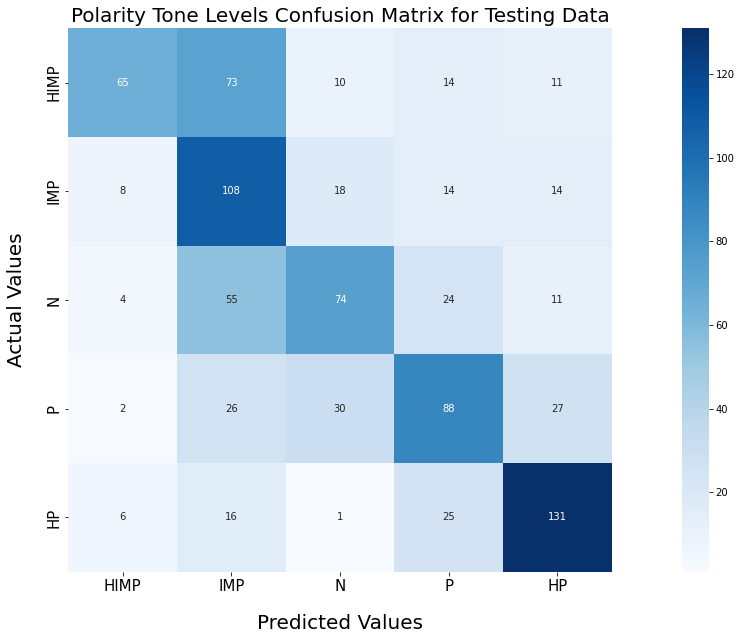

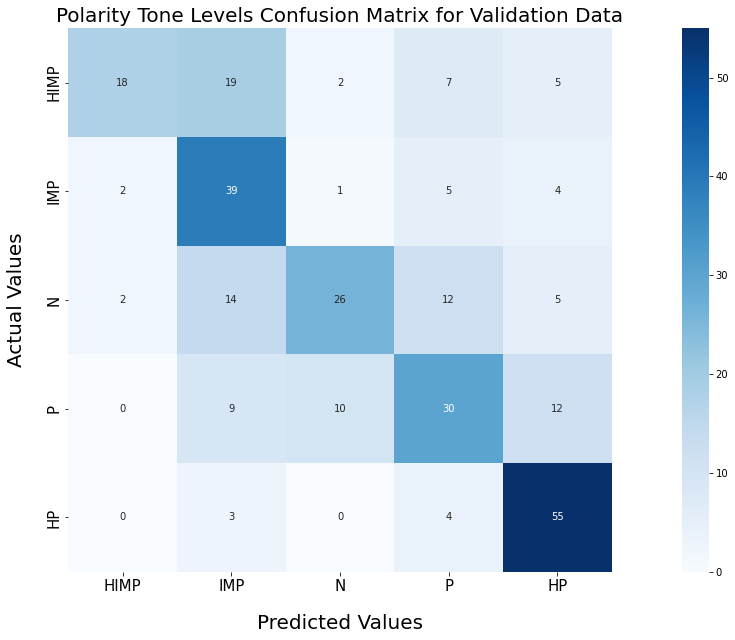

In [29]:
plt.figure(figsize=(25, 10))
sns.heatmap(cm_test, square=True, annot=True, cmap='Blues', fmt='d', cbar=True, yticklabels=politeness, xticklabels=politeness)
plt.xlabel('Predicted Values', fontsize=20, labelpad=20)
plt.ylabel('Actual Values', fontsize=20, labelpad=20)
plt.title('Polarity Tone Levels Confusion Matrix for Testing Data', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.show()


plt.figure(figsize=(25, 10))
sns.heatmap(cm_val, square=True, annot=True, cmap='Blues', fmt='d', cbar=True, yticklabels=politeness, xticklabels=politeness)
plt.xlabel('Predicted Values', fontsize=20, labelpad=20)
plt.ylabel('Actual Values', fontsize=20, labelpad=20)
plt.title('Polarity Tone Levels Confusion Matrix for Validation Data', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.show()

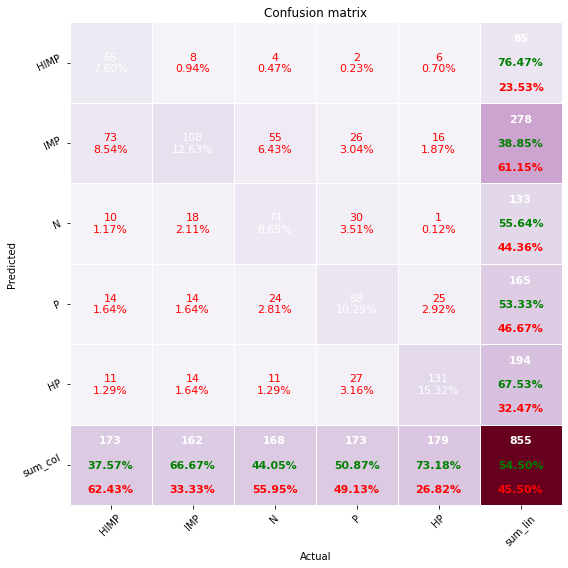

In [30]:
from pretty_confusion_matrix import pp_matrix

df_cm = pd.DataFrame(cm_test, index=politeness, columns=politeness)
cmap = 'PuRd'
pp_matrix(df_cm, cmap=cmap)

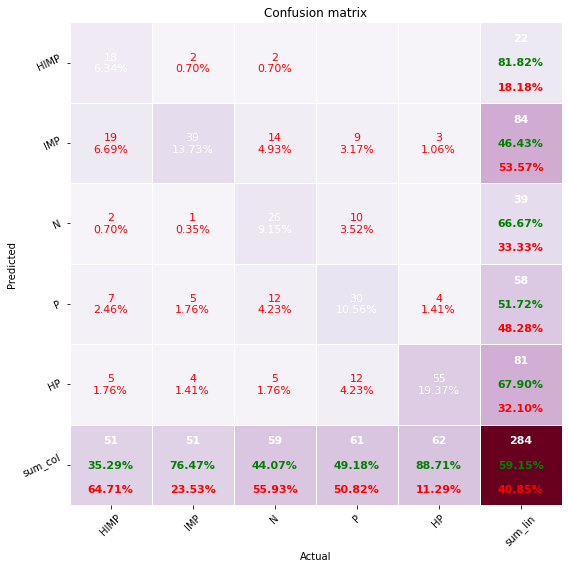

In [31]:
from pretty_confusion_matrix import pp_matrix

df_cm = pd.DataFrame(cm_val, index=politeness, columns=politeness)
cmap = 'PuRd'
pp_matrix(df_cm, cmap=cmap)

In [32]:
# CLASSIFICATION REPORT
from sklearn.metrics import classification_report

print(classification_report(y_test_true_idx, y_pred_test_idx, target_names=politeness))
print('\n\n',classification_report(y_val_true_idx, y_pred_val_idx , target_names=politeness))

              precision    recall  f1-score   support

        HIMP       0.76      0.38      0.50       173
         IMP       0.39      0.67      0.49       162
           N       0.56      0.44      0.49       168
           P       0.53      0.51      0.52       173
          HP       0.68      0.73      0.70       179

    accuracy                           0.55       855
   macro avg       0.58      0.54      0.54       855
weighted avg       0.59      0.55      0.54       855



               precision    recall  f1-score   support

        HIMP       0.82      0.35      0.49        51
         IMP       0.46      0.76      0.58        51
           N       0.67      0.44      0.53        59
           P       0.52      0.49      0.50        61
          HP       0.68      0.89      0.77        62

    accuracy                           0.59       284
   macro avg       0.63      0.59      0.57       284
weighted avg       0.63      0.59      0.58       284



# INFERENCE MODEL

In [33]:
def predictPreprocess(model, sent):
    outputs = sent2embed(model, sent)
    pred_X = np.array([outputs[1].detach().numpy()[0]])
    embed_X = tf.stack(pred_X)
    return embed_X

In [34]:
def inferenceModel(model, embed_model, sent):
    labels = y_train.columns
    sents= sent.split('.')[:-1]
    results =[]
    for s in sents:
        sample_embed = predictPreprocess(embed_model, s.strip())
        politness_probab = model.predict(sample_embed)
        politness_label_idx = np.argmax(politness_probab[0])
        results.append([labels[politness_label_idx] ])
        
    return results

In [35]:
# SAMPLE 1
sent = '''This paper presents a model-free policy gradient approach for 
reinforcement learning that combines on-policy  updates with an off-policy 
critic . The hope is to learn continuous control in a sample-efficient fashion. 
The approach  is validated on a number of low-dimensional continuous control 
tasks in a simulated environment.'''
op = inferenceModel(model,embed_model, sent)

print('PREDICTED OUTPUT :', op)

PREDICTED OUTPUT : [['P'], ['N'], ['N']]


In [36]:
# SAMPLE 2
sent = '''However , since the processing of sequential data seems to be a broad and general area of application , it is  
conceivable that this work will be useful in the design and application of 
future CNNs . All in all , this paper introduces  an interesting idea to 
address an important topic .'''
op = inferenceModel(model,embed_model, sent)

print('PREDICTED OUTPUT :', op)

PREDICTED OUTPUT : [['P'], ['P']]
